## Table of contents
* [Introduction](#introduction)
* [Business Problem & Stakeholders](#businessproblem)
* [Data](#data)
* [Data, Shopping Centre List](#centrelist)
* [Data, Shop List](#shoplist)
* [Methodology](#method)
* [Analysis](#analysis)
* [Results and Conclusion](#result)

## Introduction <a id="introduction"></a>

In Australia, online shopping is devastating retail. In 2018 alone, the number of online purchases grew by more than 13% year on year in every State and Territory. While Australia’s major metro cities still dominate online purchasing, there is also rapid growth in online shopping in regional areas. Even in remote areas of Australia, it’s clear that the households that shop online are doing more frequently and they are buying a wider variety of products. 

Foot traffic in physical stores has continously fallen. Physical stores have to create compelling reasons for customers to leave their homes and go shopping. 

Some shopping centre operators are responsing by expanding their offerrings of food, events and shopping experiences. For example, the redevelopment of the Chadstone shopping centre in Victoria included a new dine-in restaurant precinct, and movie theatre and a Lego Discovery Centre. 

This study explores physical retail shops in shopping centres across Australia, to discover what types of physical shops are popular and pickup by customers. Futhermore, it is also interesting to understand if types of physical shops are different across Australia.

<img src="3.-397014_008.jpg" width="800">

Chadstone Shopping Centre in Victoria

## Business Problem & Stakeholders <a id="businessproblem"></a>
This study helps shopping centre operators and physical restail shop owners to understand the the top picked shop typs, and its pattern across Australia. 

## Data <a id="data"></a>
Considering lots of physical retail shops are gathered in shopping centres, this study makes use of Australian shopping centers as the starting point. Then we use Foursquare APIs to explore top picked shops within or near each shopping centre. 

* The wikipedia link provides a list of shopping centers in Australia https://en.wikipedia.org/wiki/List_of_shopping_centres_in_Australia)

* Top picked shops and its types are obtained by Foursquare API

Important Notes,

* 1, In this study, the top picked shops are obtained directly from Foursquare recommendation. The data therefore could be biased by Foursquare engine. Ideally, we shall use checkin statstic data of each shops to decide shops' rank, rather than a simple return from Foursquare engine.

* 2, The shopping centre list provided from wikipedia is not completed and up-to-date, further coordinate data of some centres are also missed. This study simpily ignore those not well formated data. 



## Shopping Centre List <a id="centrelist"></a>
The wikipedia link provides the majority shopping centers in Austalia. 
For each shopping center, normally a detailed wikipedia link associated. The detailed page provides coordinates, which can be preapred for Foursquare API.
We have noticed that not all shopping centers have the detailed page associatd. This study will simply ignore these shopping centers if the detailed pages are not existed. 

My family live in Melbourne Austrlia. My wife likes shopping at Chadstone Shopping Centre, let's take Chadstone Shopping Centre as a check point along with this study.

* Example Data

Chadstone Shopping Centre in Victoria is recorded in the wikipedia shopping centre list(https://en.wikipedia.org/wiki/List_of_shopping_centres_in_Australia). The assoicatd detailed page is also found from wikpedia (https://en.wikipedia.org/wiki/Chadstone_Shopping_Centre), the page provides coordinate 37°53′9″S 145°4′57″E. 

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
import bs4
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [3]:
import re
import folium
import math

In [90]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [138]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [4]:
#shopping_venues = pd.read_csv("shopping_venues.csv")
#shoppingcentrepd = pd.read_csv("shopping_centres.csv")

Fetch and parse shopping centre list from wikipeida

In [168]:
shoppinglisturl = "https://en.wikipedia.org/wiki/List_of_shopping_centres_in_Australia"
baseurl = 'https://en.wikipedia.org/'

In [169]:
mainpage = requests.get(shoppinglisturl)

In [170]:
mainsoup = BeautifulSoup(mainpage.text, 'html.parser')

In [171]:
statelist = mainsoup.find_all(name='div', attrs={'class':'mw-content-ltr'} )[0].find_all(name='h2')

In [172]:
shoppingcentrelist = []
for astate in statelist:
    statecontent = astate.find_all(name='span', attrs={'class':'mw-headline'})
    if len(statecontent)>0:
        statename = statecontent[0].get_text(strip=True)
        if statename == 'See also':
            break
        #print(statename)
        shoptag = astate.find_next_sibling(name='ul')
        cenlist = shoptag.find_all(name="li")
        for acen in cenlist:
            aitem = acen.contents[0]
            try:
                if aitem.name == 'a':
                    detailurl = urljoin(baseurl, aitem['href'])
                    #print(aitem.get_text() + "- " + detailurl)
                    #print("\n")
                    shoppingcentrelist.append([statename, aitem.get_text(), detailurl])
            except TypeError:
                pass
        nextshoptag = shoptag.next_sibling.next_sibling
        while nextshoptag.name == 'h3':
            shoptag = nextshoptag.find_next_sibling(name='ul')
            cenlist = shoptag.find_all(name="li")
            for acen in cenlist:
                aitem = acen.contents[0]
                try:
                    if aitem.name == 'a':
                        detailurl = urljoin(baseurl, aitem['href'])
                        #print(aitem.get_text() + "- " + detailurl)
                        #print("\n")
                        shoppingcentrelist.append([statename, aitem.get_text(), detailurl])
                except TypeError:
                    pass
            nextshoptag = shoptag.next_sibling.next_sibling

In [173]:
shoppingcentrepd = pd.DataFrame(data=shoppingcentrelist, columns=["State", "shopping centre", "url"])

In [174]:
shoppingcentrepd.head()

,State,shopping centre,url
0,Australian Capital Territory,Canberra Centre,https://en.wikipedia.org/wiki/Canberra_Centre
1,Australian Capital Territory,Erindale Centre,https://en.wikipedia.org/wiki/Erindale_Centre
2,Australian Capital Territory,Kippax Fair,https://en.wikipedia.org/wiki/Kippax_Fair
3,Australian Capital Territory,Majura Park Shopping Centre,https://en.wikipedia.org/wiki/Majura_Park_Shop...
4,Australian Capital Territory,South.Point Tuggeranong,https://en.wikipedia.org/wiki/South.Point_Tugg...


In [175]:
shoppingcentrepd.shape

(276, 3)

Total 276 shopping centres are retrived from Wiki pages, which associates a detailed wiki page. Now we obtain latitude & longtitude by following the detailed page url.

In [176]:
def fetchcoordinates(arow):
    print("Processing ... " + arow["url"])
    detailpage = requests.get(arow["url"])
    detailsoup = BeautifulSoup(detailpage.text, 'html.parser')
    coorddata = detailsoup.find_all(name='span', attrs={'class':'geo-dms'})
    if len(coorddata) > 0:
        #print(coorddata)
        lat = coorddata[0].find(name='span', attrs={'class':'latitude'}).get_text()
        lon = coorddata[0].find(name='span', attrs={'class':'longitude'}).get_text()
        return lat + "," + lon
    else:
        return ""

In [177]:
shoppingcentrepd["Coordinate"] = shoppingcentrepd.apply(fetchcoordinates, axis=1)

Processing ... https://en.wikipedia.org/wiki/Canberra_Centre
Processing ... https://en.wikipedia.org/wiki/Erindale_Centre
Processing ... https://en.wikipedia.org/wiki/Kippax_Fair
Processing ... https://en.wikipedia.org/wiki/Majura_Park_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/South.Point_Tuggeranong
Processing ... https://en.wikipedia.org/wiki/Westfield_Belconnen
Processing ... https://en.wikipedia.org/wiki/Westfield_Woden
Processing ... https://en.wikipedia.org/wiki/Broadway_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/Central_Park,_Sydney
Processing ... https://en.wikipedia.org/wiki/The_Galeries_Victoria
Processing ... https://en.wikipedia.org/wiki/Harbourside_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/Mid_City_Centre
Processing ... https://en.wikipedia.org/wiki/MLC_Centre
Processing ... https://en.wikipedia.org/wiki/Queen_Victoria_Building,_Sydney
Processing ... https://en.wikipedia.org/wiki/Soul_Pattinson_Building
Processing ...

Processing ... https://en.wikipedia.org/wiki/Brisbane_Arcade
Processing ... https://en.wikipedia.org/wiki/Broadway_on_the_Mall,_Brisbane
Processing ... https://en.wikipedia.org/wiki/MacArthur_Central
Processing ... https://en.wikipedia.org/wiki/The_Myer_Centre,_Brisbane
Processing ... https://en.wikipedia.org/wiki/Post_Office_Square,_Brisbane
Processing ... https://en.wikipedia.org/wiki/Queen_Street_Mall,_Brisbane
Processing ... https://en.wikipedia.org/wiki/QueensPlaza
Processing ... https://en.wikipedia.org/wiki/Wintergarden,_Brisbane
Processing ... https://en.wikipedia.org/w/index.php?title=Arndale_Shopping_Centre&action=edit&redlink=1
Processing ... https://en.wikipedia.org/w/index.php?title=Aspley_Hypermarket&action=edit&redlink=1
Processing ... https://en.wikipedia.org/w/index.php?title=Booval_Fair&action=edit&redlink=1
Processing ... https://en.wikipedia.org/wiki/Brookside_Shopping_Centre
Processing ... https://en.wikipedia.org/w/index.php?title=Calamvale_Central_Shopping_Centre

Processing ... https://en.wikipedia.org/wiki/Epping_Plaza
Processing ... https://en.wikipedia.org/wiki/Essendon_Fields,_Victoria
Processing ... https://en.wikipedia.org/wiki/Forest_Hill_Chase_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/Greensborough_Plaza
Processing ... https://en.wikipedia.org/wiki/Highpoint_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/Karingal_Hub_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/Northcote_Shopping_Plaza
Processing ... https://en.wikipedia.org/wiki/Northland_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/Parkmore_Shopping_Centre
Processing ... https://en.wikipedia.org/wiki/Pacific_Werribee
Processing ... https://en.wikipedia.org/wiki/Pran_Central
Processing ... https://en.wikipedia.org/wiki/Stockland
Processing ... https://en.wikipedia.org/wiki/Stockland
Processing ... https://en.wikipedia.org/wiki/Stockland_The_Pines
Processing ... https://en.wikipedia.org/wiki/Stockland_Tooronga
Processing .

In [178]:
shoppingcentrepd.head()

,State,shopping centre,url,Coordinate
0,Australian Capital Territory,Canberra Centre,https://en.wikipedia.org/wiki/Canberra_Centre,"35°16′50″S,149°08′0″E"
1,Australian Capital Territory,Erindale Centre,https://en.wikipedia.org/wiki/Erindale_Centre,"35°24′11″S,149°05′56″E"
2,Australian Capital Territory,Kippax Fair,https://en.wikipedia.org/wiki/Kippax_Fair,"35°13′21″S,149°01′12″E"
3,Australian Capital Territory,Majura Park Shopping Centre,https://en.wikipedia.org/wiki/Majura_Park_Shop...,"35°17′57″S,149°11′27″E"
4,Australian Capital Territory,South.Point Tuggeranong,https://en.wikipedia.org/wiki/South.Point_Tugg...,"35°24′59″S,149°03′59″E"


Further ignore shop centres, if coordinate is not provided. Now the total number of shopping centres is 200. 
Then we convert coordinate into decimal format.

In [179]:
shoppingcentrepd = shoppingcentrepd[shoppingcentrepd['Coordinate']!=""]

In [180]:
shoppingcentrepd.shape

(200, 4)

In [181]:
def convert_decimal (coordinate):
    # generate the decimal multiplier (if coordinate is S or V, then the
    # decimal representation is negative
    multiplier = 1
    if coordinate.endswith('S') or coordinate.endswith('W'):
        multiplier = -1
    # split coordinate in 3 components and cast them to numbers
    components = coordinate[:-1].split('.')
    degrees = int(components[0])
    minutes = int(components[1])
    if (components[2].isnumeric()):
        seconds = int(components[2])
    else:
        seconds = 0
    # compute decimal coordinate with max 5 decimals
    decimal_coordinate = float("{0:.5f}".format(multiplier * (degrees + (minutes / 60) + (seconds / 3600))))
    return decimal_coordinate

In [182]:
def processcoordinate(arow):
    if arow["Coordinate"] != "":
        coordinate = re.sub('[°′″]', '.',arow["Coordinate"])
        aa = coordinate.split(',')
        #print(aa)
        arow["latitude"] = convert_decimal(aa[0])
        arow["longitude"] = convert_decimal(aa[1])
    else:
        arow["latitude"] = ""
        arow["longitude"] = ""
    return arow

In [183]:
shoppingcentrepd = shoppingcentrepd.apply(processcoordinate, axis=1)

In [184]:
shoppingcentrepd.head()

,State,shopping centre,url,Coordinate,latitude,longitude
0,Australian Capital Territory,Canberra Centre,https://en.wikipedia.org/wiki/Canberra_Centre,"35°16′50″S,149°08′0″E",-35.28056,149.13333
1,Australian Capital Territory,Erindale Centre,https://en.wikipedia.org/wiki/Erindale_Centre,"35°24′11″S,149°05′56″E",-35.40306,149.09889
2,Australian Capital Territory,Kippax Fair,https://en.wikipedia.org/wiki/Kippax_Fair,"35°13′21″S,149°01′12″E",-35.22250,149.02000
3,Australian Capital Territory,Majura Park Shopping Centre,https://en.wikipedia.org/wiki/Majura_Park_Shop...,"35°17′57″S,149°11′27″E",-35.29917,149.19083
4,Australian Capital Territory,South.Point Tuggeranong,https://en.wikipedia.org/wiki/South.Point_Tugg...,"35°24′59″S,149°03′59″E",-35.41639,149.06639


Let's visualize shopping centres physical location on the Australian map, by centreing from Chadstone shopping centre. This verifies if obtained coordinates are correct.

In [185]:
shoppingcentrepd[shoppingcentrepd["shopping centre"] == 'Chadstone Shopping Centre']

,State,shopping centre,url,Coordinate,latitude,longitude
213,Victoria,Chadstone Shopping Centre,https://en.wikipedia.org/wiki/Chadstone_Shoppi...,"37°53′9″S,145°4′57″E",-37.88583,145.0825


In [248]:
latitude = -37.88583
longitude = 145.0825

In [249]:
# create map using latitude and longitude values
map_shoppingcentre = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, state, shoppingcentre in zip(shoppingcentrepd['latitude'], shoppingcentrepd['longitude'], shoppingcentrepd['State'], shoppingcentrepd['shopping centre']):
    label = '{}@{}'.format(shoppingcentre, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_shoppingcentre)

In [250]:
map_shoppingcentre

The map shows the correct location of chadstone shopping centre. Now we inspect the shoping centre location distribution in the Australian map.

In [251]:
map_shoppingcentre.zoom_start=10
map_shoppingcentre

The shopping centres data are all in the major cities of Australia, no shopping centres are from the centre of Australia. Further, most of the shopping centres are from east area of Australia. On othe other side, we only can see Perth, Darwin and Hobart have big shopping centre recorded in Wikipedia. 

From this distribution, we can say most of Australian population live in the major cities, espeically in east of Australia.  

## Shop details <a id="shoplist"></a>
We use Foursquare API Explore Venues Recommendation to obtain up to 100 shops. The neighborhoods are defined as circular areas from the centre of shopping centres, with a radius of 1,000 meters. 

* The API format is following:

'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&time=any&day=any&openNow=0&sortByPopularity=1&saved=0'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)

The search requires no restriction on open time and return data will be sorted by popularity.

The Foursquare API provides hierarchy of venue categories, as example snapshot is displayed as below. This study consolidates categories into the 2nd level. 

<img src="shopcat.JPG" width="400">

I found Foursquare API does not provide consistent category on the return message. I enforce the mapping returned venues into 2nd level of category, such as "Asian Restaurant".

In order to do so, I firstly use Foursquare API to get the completed categories, and then build a directory map.

In [ ]:
CLIENT_ID = '1WYYDTX1IAW1RBHWNSWFFNWBISPNYIRDF41QJ54XSLZZWJ10' # your Foursquare ID
CLIENT_SECRET = '2KMCUD2YU4CILS2KK0Y5W301NY4BPZ1G1KLAGIOPPT5AEXAQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
radius=1000
#section='topPicks'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Obtain Foursquare categories, and build it into dictionary

In [2]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)

In [7]:
categoriesjson = requests.get(url).json()

In [8]:
def buildCatlist (data):
    mylist = []
    for acat in data['categories']:
        mylist.append(acat['name'])
        mysubs = buildCatlist(acat)
        if len(mysubs) > 0:
            mylist.extend(mysubs)
    return mylist

In [141]:
def buildCategories(data):
    catlist = {}
    seclist = []
    foodlist = []
    for amain in data["response"]["categories"]:
        maincat = amain['name']
        print('process ... ' + maincat)
        if (amain['categories'] != ""):
            for asecond in amain['categories']:
                secondcat = asecond['name']
                seclist.append(secondcat)
                if maincat == 'Food':
                    foodlist.append(secondcat)
                    
                subcat = buildCatlist(asecond)
                if len(subcat) > 0:
                    if maincat == 'Food':
                        foodlist.extend(subcat)
                    for aitem in subcat:
                        catlist[aitem] = secondcat
    return catlist, seclist, foodlist

In [142]:
catdict, secondlevelcat, foodlist = buildCategories(categoriesjson)

process ... Arts & Entertainment
process ... College & University
process ... Event
process ... Food
process ... Nightlife Spot
process ... Outdoors & Recreation
process ... Professional & Other Places
process ... Residence
process ... Shop & Service
process ... Travel & Transport


In [12]:
print('total {} in categories in second level categories '.format(len(secondlevelcat)) )

total 456 in categories in second level categories 


In [50]:
def getNearbyVenus(row):
    
    specialcat = {'Homemaker Centre':'Home Service',
                 'The Meat Market':'Food & Drink Shop',
                 'Hawthorn Velodrome':'Athletics & Sports',
                 'The Brickpit':'Athletics & Sports',
                 'Sakura Sushi':'Japanese Restaurant',
                 'The Barra Bar':'Bar',
                 'Frankston Home Maker Centre':'Home Service'}
    neighborhood_latitude = row['latitude'] # neighborhood latitude value
    neighborhood_longitude = row['longitude'] # neighborhood longitude value
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&time=any&day=any&openNow=0&sortByPopularity=1&saved=0'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    print("processing " + row["shopping centre"] + " venue: " + str(len(results)))
    
    venues_list=[]
    for v in results:
        avname = v['venue']['name']
        if avname in specialcat:
            acat = specialcat[avname]
        else:
            acat =  v['venue']['categories'][0]['name']
            if acat not in secondlevelcat:
                try:
                    acat = catdict[acat]
                except KeyError:
                    print(v)
                    pass
        venues_list.append([
            row["State"],
            row["shopping centre"],
            neighborhood_latitude, 
            neighborhood_longitude, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
           acat])
        
    return(venues_list)

In [51]:
venues_list=[]
for i in range(len(shoppingcentrepd)):
    venues_list.extend(getNearbyVenus(shoppingcentrepd.iloc[i]))

processing Canberra Centre venue: 100
processing Erindale Centre venue: 19
processing Kippax Fair venue: 16
processing Majura Park Shopping Centre venue: 24
processing South.Point Tuggeranong venue: 36
processing Westfield Belconnen venue: 69
processing Westfield Woden venue: 43
processing Broadway Shopping Centre venue: 100
processing Central Park Mall venue: 100
processing The Galeries Victoria venue: 100
processing Harbourside Shopping Centre venue: 100
processing Mid City Centre venue: 100
processing MLC Centre venue: 100
processing Queen Victoria Building venue: 100
processing Soul Pattinson Building venue: 100
processing Stockland Glasshouse venue: 100
processing The Strand Arcade venue: 100
processing Westfield Sydney venue: 100
processing World Square venue: 100
processing Bankstown Central venue: 69
processing Bass Hill Plaza venue: 18
processing Birkenhead Point Outlet Centre venue: 46
processing Burwood Plaza venue: 65
processing Carlingford Court venue: 32
processing Castle

processing Riverside Plaza venue: 82
{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e884fcb9adfe9f4e172a33c', 'name': 'Twin Cities Marathon Starting Line', 'location': {'lat': 44.97359738986836, 'lng': -93.26022300239599, 'labeledLatLngs': [{'label': 'display', 'lat': 44.97359738986836, 'lng': -93.26022300239599}], 'distance': 978, 'cc': 'US', 'city': 'Minneapolis', 'state': 'MN', 'country': 'United States', 'formattedAddress': ['Minneapolis, MN', 'United States']}, 'categories': [{'id': '4d4b7105d754a06377d81259', 'name': 'Outdoors & Recreation', 'pluralName': 'Outdoors & Recreation', 'shortName': 'Outdoors & Recreation', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e884fcb9adfe9f4e172a33c-71'}
processing Stockland Wendouree venue: 11
processing S

In [52]:
shopping_venues = pd.DataFrame(data=venues_list, columns = ['State','shopping centre', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

Since "shopping mall" is alreadly under this study, let's remove "shopping mall" category.

In [56]:
shopping_venues = shopping_venues[shopping_venues['Venue Category'] != 'Shopping Mall']

We also remove "Park" catetory, since it is not related with shopping.

In [57]:
shopping_venues = shopping_venues[shopping_venues['Venue Category'] != 'Park']

In [53]:
shopping_venues.head()

,State,shopping centre,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Australian Capital Territory,Canberra Centre,-35.28056,149.13333,Canberra Centre,-35.280422,149.132817,Shopping Mall
1,Australian Capital Territory,Canberra Centre,-35.28056,149.13333,Garema Place,-35.278245,149.131847,Plaza
2,Australian Capital Territory,Canberra Centre,-35.28056,149.13333,Lower Ground Food Court,-35.280299,149.133199,Food Court
3,Australian Capital Territory,Canberra Centre,-35.28056,149.13333,Dendy Cinemas,-35.277595,149.132742,Movie Theater
4,Australian Capital Territory,Canberra Centre,-35.28056,149.13333,Apple Canberra,-35.280284,149.133653,Electronics Store


Let's inspect shops from chadstone shopping centre, to verify if they are correct shops, and if they are popular.

In [5]:
shopping_venues[shopping_venues['shopping centre'] == 'Chadstone Shopping Centre'][["Venue", "Venue Category"]].head(20)

,Venue,Venue Category
7508,Kmart,Department Store
7509,David Jones,Department Store
7510,Hoyts,Movie Theater
7511,Uniqlo,Clothing Store
7512,Coles,Food & Drink Shop
7513,Woolworths,Food & Drink Shop
7514,Myer,Department Store
7515,JB Hi-Fi,Electronics Store
7516,Apple Chadstone,Electronics Store
7517,Lindt Chocolat Café,Café


The list sounds good. My wife indeed like Nando's and Daiso.

In [6]:
print('Total {} shops are obtained.'.format(shopping_venues.shape[0]) )

Total 9952 shops are obtained.


In [7]:
print('There are {} uniques categories.'.format(len(shopping_venues['Venue Category'].unique())))

There are 229 uniques categories.


I stored retrived data as CSV into local, for further study in next steps.

In [ ]:
#shopping_venues.to_csv("shopping_venues.csv")
#shoppingcentrepd.to_csv("shopping_centres.csv", index=False)

## Methodology <a name="method"></a>
In this study, we will detect what types of retail shops are popular, that will help stakeholders to attrack foot traffic. Further, we will investigate how types of retails shops are different across Australia. 

In the above first step, we already collected all the top picked shop list among major Australian shopping centres, and their categories.

In the second step, we will count number of shops in each category across the whoel Australia. This will help us to find out the most popular shop type.

In the third step, we will explore characters of each shopping center. Then we will cluster shopping centres by k-mean, to detect if shopping centers can be classified by different groups. 

## Analysis <a name="analysis"></a>

Let's convert shopping category as one-hot vector, so that we can count number of shops in each category, and then we can compare shop categories.

In [20]:
# one hot encoding
shopping_onehot = pd.get_dummies(shopping_venues[['Venue Category']], prefix="", prefix_sep="")

shopping_onehot['State'] = shopping_venues['State']
shopping_onehot['shopping centre'] = shopping_venues['shopping centre']


# move neighborhood column to the first column
columnlist = shopping_onehot.columns.values
fixed_columns = columnlist[-2:] 
fixed_columns = np.hstack((fixed_columns, columnlist[:-2]))
shopping_onehot = shopping_onehot[fixed_columns]

In [30]:
shopping_onehot.set_index(['State','shopping centre'], inplace=True)

In [31]:
shopping_onehot.shape

(9952, 229)

In [32]:
shopping_onehot.head()

ATM  Afghan Restaurant  \
State                        shopping centre                           
Australian Capital Territory Canberra Centre    0                  0   
                             Canberra Centre    0                  0   
                             Canberra Centre    0                  0   
                             Canberra Centre    0                  0   
                             Canberra Centre    0                  0   

                                              African Restaurant  Airport  \
State                        shopping centre                                
Australian Capital Territory Canberra Centre                   0        0   
                             Canberra Centre                   0        0   
                             Canberra Centre                   0        0   
                             Canberra Centre                   0        0   
                             Canberra Centre                   0        0   

                                              American Restaurant  \
State                        shopping centre                        
Australian Capital Territory Canberra Centre                    0   
                             Canberra Centre                    0   
                             Canberra Centre                    0   
                             Canberra Centre                    0   
                             Canberra Centre                    0   

                                              Antique Shop  Aquarium  Arcade  \
State                        shopping centre                                   
Australian Capital Territory Canberra Centre             0         0       0   
                             Canberra Centre             0         0       0   
                             Canberra Centre             0         0       0   
                             Canberra Centre             0         0       0   
                             Canberra Centre             0         0       0   

                                              Art Gallery  \
State                        shopping centre                
Australian Capital Territory Canberra Centre            0   
                             Canberra Centre            0   
                             Canberra Centre            0   
                             Canberra Centre            0   
                             Canberra Centre            0   

                                              Arts & Crafts Store ...   \
State                        shopping centre                      ...    
Australian Capital Territory Canberra Centre                    0 ...    
                             Canberra Centre                    0 ...    
                             Canberra Centre                    0 ...    
                             Canberra Centre                    0 ...    
                             Canberra Centre                    0 ...    

                                              Turkish Restaurant  \
State                        shopping centre                       
Australian Capital Territory Canberra Centre                   0   
                             Canberra Centre                   0   
                             Canberra Centre                   0   
                             Canberra Centre                   0   
                             Canberra Centre                   0   

                                              Vegetarian / Vegan Restaurant  \
State                        shopping centre                                  
Australian Capital Territory Canberra Centre                              0   
                             Canberra Centre                              0   
                             Canberra Centre                              0   
                             Canberra Centre                              0   
                             Canberra Centre              

Let's find out most popular shop categories.

In [33]:
shopping_cat = shopping_onehot.sum(axis=0).sort_values(ascending=False)

In [34]:
shopping_cat[:30]

Asian Restaurant         1159
Café                      887
Bar                       623
Hotel                     543
Coffee Shop               525
Food & Drink Shop         494
Fast Food Restaurant      341
Athletics & Sports        324
Dessert Shop              221
Department Store          192
Burger Joint              191
Electronics Store         174
Clothing Store            164
Sandwich Place            156
Pizza Place               151
Italian Restaurant        151
Australian Restaurant     141
Movie Theater             140
Juice Bar                 121
Performing Arts Venue     112
Bakery                    111
Mexican Restaurant        109
Food Court                 89
Plaza                      88
Steakhouse                 81
Restaurant                 80
Museum                     80
Pharmacy                   78
Indian Restaurant          77
Portuguese Restaurant      73
dtype: int64

In [35]:
shoppinglist_cattop = shopping_cat.head(30)

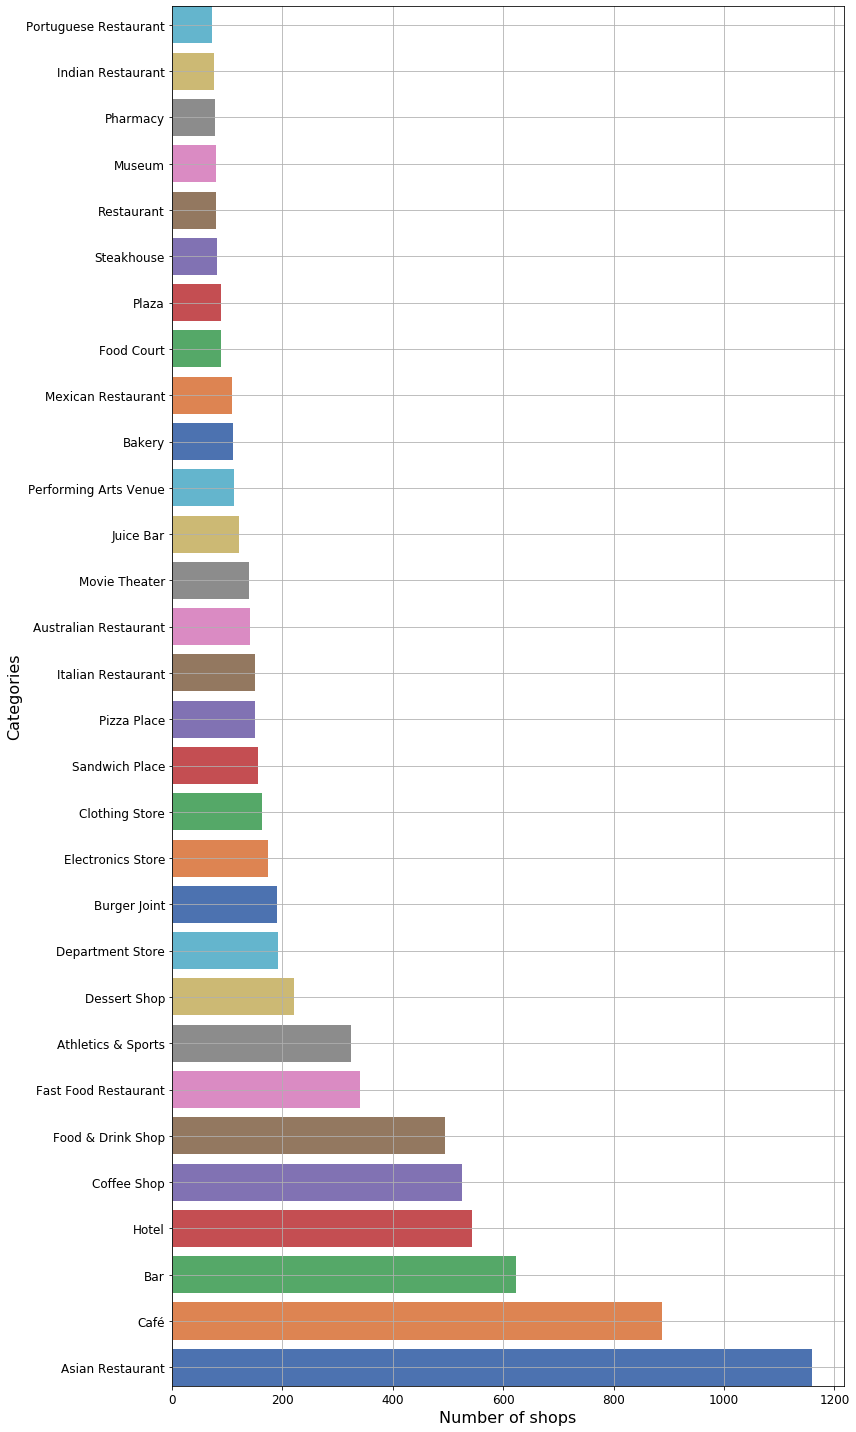

In [36]:
plt.figure(figsize=(12, 20))
plt.barh(shoppinglist_cattop.index, shoppinglist_cattop.values, color=sns.color_palette('deep'))
plt.xlabel('Number of shops', fontsize=16)
plt.ylabel('Categories', fontsize=16)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.grid(True)
plt.margins(y=0)
plt.savefig("shoplist.jpg")
plt.show()

It is no suprise to see food type of shops (Restaurant, Cafe, Bar etc.) occupy large percentage in the shopping centre. But it sounds a little bit suprise to have Asian Restaurant in first place, rather than Australian Restaurant. Australia is a migration country, an mix up different cultures. And Australian love Asian food!

Hotels tend to be near shopping centres. That shall bring convenience to travellers, meanwhile hotels direct people traffic to the shopping centres.

Australian love sports, it is no wonder have "Athletics & Sports" in/near the shopping centres, that shall serve good meet-points.

It is not weird to have Pharmacy in the top 30 list. In Australia, the Pharmacy not only provides medicines, but all kinds of skin care, makeup etc.

Let's continue to explore different shopping characters by states.

In [42]:
shopping_state = shopping_onehot.groupby("State").sum()
shopping_state.reset_index(inplace=True)

In [43]:
shopping_state

,State,ATM,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse,Warehouse Store,Water Park,Winery,Wings Joint,Zoo
0,Australian Capital Territory,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,New South Wales,0.0,1.0,0.0,0.0,2.0,0.0,10.0,0.0,9.0,...,2.0,7.0,7.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0
2,Northern Territory,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Queensland,0.0,0.0,1.0,0.0,3.0,0.0,1.0,2.0,17.0,...,1.0,9.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0
4,South Australia,0.0,1.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,...,0.0,13.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,Tasmania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Victoria,1.0,2.0,1.0,1.0,6.0,2.0,1.0,0.0,17.0,...,1.0,6.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
7,Western Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,...,0.0,12.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['State']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['State'] = shopping_state['State']

for ind in np.arange(shopping_state.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(shopping_state.iloc[ind, :], num_top_venues)

In [46]:
neighborhoods_venues_sorted

,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Australian Capital Territory,Asian Restaurant,Café,Coffee Shop,Bar,Athletics & Sports,Food & Drink Shop,Fast Food Restaurant,Dessert Shop,Electronics Store,Sandwich Place
1,New South Wales,Asian Restaurant,Café,Coffee Shop,Food & Drink Shop,Hotel,Athletics & Sports,Bar,Fast Food Restaurant,Dessert Shop,Electronics Store
2,Northern Territory,Hotel,Asian Restaurant,Bar,Café,Fast Food Restaurant,Coffee Shop,Australian Restaurant,Steakhouse,Department Store,Food & Drink Shop
3,Queensland,Hotel,Café,Asian Restaurant,Bar,Food & Drink Shop,Coffee Shop,Fast Food Restaurant,Burger Joint,Clothing Store,Italian Restaurant
4,South Australia,Bar,Asian Restaurant,Café,Hotel,Food & Drink Shop,Coffee Shop,Italian Restaurant,Dessert Shop,Sculpture Garden,Athletics & Sports
5,Tasmania,Food & Drink Shop,Fast Food Restaurant,Department Store,Café,Sandwich Place,Bakery,Asian Restaurant,Pizza Place,Athletics & Sports,Movie Theater
6,Victoria,Asian Restaurant,Café,Bar,Coffee Shop,Food & Drink Shop,Fast Food Restaurant,Athletics & Sports,Hotel,Department Store,Performing Arts Venue
7,Western Australia,Asian Restaurant,Hotel,Bar,Coffee Shop,Café,Food & Drink Shop,Dessert Shop,Fast Food Restaurant,Department Store,Athletics & Sports


The top three "Asian Restaurant", "Bar", "Cafe" overwhelm other shops. Obviously, these three have widely presented across all Australian shop centres. 

In order to character different shopping centres, let's use TF-IDF concept to weight down those frequent shop types.

The following terms are defined for the calcuation:

* Shopping category frequency (shoppingtf) = (frequency of the category in its shopping centre / total number of categories in its shopping centre)

* Total number of shopping centrers (totalcentres)

* Showing centre frequency (shoppingdf) = number of shopping centres associated with the category

* Shopping category inversed frequency (shoppingidf) = ln (totalcentres / (1+shoppingdf))

* Weighted shopping category frequency (shoppingtfidf) = shoppingtf * shoppingidf

In [215]:
shoppingbycenter = shopping_onehot.groupby("shopping centre").sum()

In [216]:
shoppingbycenter.head()

,ATM,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse,Warehouse Store,Water Park,Winery,Wings Joint,Zoo
shopping centre,,,,,,,,,,,,,,,,,,,,,
ANZAC Square Arcade,0,0,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,0
Adelaide Arcade,0,0,0,0,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
Adelaide Central Market,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Armadale Shopping City,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bankstown Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [217]:
shoppingtf = shoppingbycenter.div(shoppingbycenter.sum(axis=1), axis="index")  

In [218]:
shoppingtf.head()

,ATM,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse,Warehouse Store,Water Park,Winery,Wings Joint,Zoo
shopping centre,,,,,,,,,,,,,,,,,,,,,
ANZAC Square Arcade,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.021277,0.0,...,0.0,0.010638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adelaide Arcade,0.0,0.0,0.0,0.0,0.010638,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adelaide Central Market,0.0,0.0,0.0,0.0,0.010526,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.010526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Armadale Shopping City,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bankstown Central,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
totalcentres = shoppingtf.shape[0]

In [220]:
print("Total shopping centres is {}".format(totalcentres))

Total shopping centres is 199


In [221]:
shoppingdf = shoppingbycenter.copy()

In [222]:
shoppingdf[shoppingdf > 1] = 1

In [223]:
shoppingdf = shoppingdf.sum(axis=0)

In [224]:
shoppingdf.sort_values(ascending=False).head(10)

Food & Drink Shop       187
Café                    170
Asian Restaurant        160
Coffee Shop             151
Athletics & Sports      151
Fast Food Restaurant    132
Sandwich Place          128
Electronics Store       124
Bar                     122
Department Store        110
dtype: int64

In [225]:
shoppingidf = (totalcentres/ (1 + shoppingdf)).apply(math.log)

In [226]:
shoppingidf.sort_values(ascending=True).head(10)

Food & Drink Shop       0.056863
Café                    0.151641
Asian Restaurant        0.211900
Coffee Shop             0.269424
Athletics & Sports      0.269424
Fast Food Restaurant    0.402956
Sandwich Place          0.433492
Electronics Store       0.464991
Bar                     0.481120
Pizza Place             0.583775
dtype: float64

Let's select Art Gallery of ANZAC Square Arcade shopping centre for a verification

In [227]:
shoppingidf['Art Gallery'] * shoppingtf.loc[['ANZAC Square Arcade'],'Art Gallery']

shopping centre
ANZAC Square Arcade    0.034137
Name: Art Gallery, dtype: float64

In [228]:
shoppingtfidf = shoppingtf.multiply(shoppingidf, axis="columns")

In [229]:
shoppingtfidf.head()

,ATM,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse,Warehouse Store,Water Park,Winery,Wings Joint,Zoo
shopping centre,,,,,,,,,,,,,,,,,,,,,
ANZAC Square Arcade,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.034137,0.0,...,0.0,0.019442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adelaide Arcade,0.0,0.0,0.0,0.0,0.026816,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.038884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adelaide Central Market,0.0,0.0,0.0,0.0,0.026534,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.019238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Armadale Shopping City,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bankstown Central,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we've got the TF-IDF encoding, let's redo the sorting for each state.

In [230]:
shoppingtfidf.reset_index(inplace=True)
shoppingtfidf = shoppingtfidf.merge(shoppingcentrepd[['State', 'shopping centre']], on='shopping centre', how='left')

In [231]:
shoppingtfidf.head()

,shopping centre,ATM,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse,Warehouse Store,Water Park,Winery,Wings Joint,Zoo,State
0,ANZAC Square Arcade,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.034137,...,0.019442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Queensland
1,Adelaide Arcade,0.0,0.0,0.0,0.0,0.026816,0.0,0.0,0.0,0.000000,...,0.038884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,South Australia
2,Adelaide Central Market,0.0,0.0,0.0,0.0,0.026534,0.0,0.0,0.0,0.000000,...,0.019238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,South Australia
3,Armadale Shopping City,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Western Australia
4,Bankstown Central,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,New South Wales


In [232]:
shopping_state2 = shoppingtfidf.groupby("State", as_index=False).sum()

In [233]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['State']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['State'] = shopping_state2['State']

for ind in np.arange(shopping_state2.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(shopping_state2.iloc[ind, :], num_top_venues)


In [234]:
neighborhoods_venues_sorted2

,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Australian Capital Territory,Airport,Rental Car Location,Hot Dog Joint,Bus Stop,Home Service,Asian Restaurant,Pizza Place,Newsstand,Bar,Shopping Plaza
1,New South Wales,Asian Restaurant,Fast Food Restaurant,Hotel,Middle Eastern Restaurant,Furniture / Home Store,Bar,Department Store,Café,Food Court,Athletics & Sports
2,Northern Territory,Flea Market,Bus Station,Fast Food Restaurant,Steakhouse,Mobile Phone Shop,Hotel,Record Shop,Bar,Fried Chicken Joint,Australian Restaurant
3,Queensland,Hotel,Campground,Fast Food Restaurant,Bar,Department Store,Clothing Store,Coffee Shop,Historic Site,Drugstore,Donut Shop
4,South Australia,Sculpture Garden,Bar,Hotel,Gas Station,Music Store,Italian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Stadium
5,Tasmania,Field,Video Store,Beach,Bakery,Child Care Service,Video Game Store,Gastropub,Fast Food Restaurant,Fried Chicken Joint,Discount Store
6,Victoria,Fast Food Restaurant,Bar,Portuguese Restaurant,Business Service,Asian Restaurant,Department Store,Donut Shop,Clothing Store,Convenience Store,Hotel
7,Western Australia,Pharmacy,Department Store,Fast Food Restaurant,Hotel,Bar,Cosmetics Shop,Dessert Shop,Indian Restaurant,Brewery,Asian Restaurant


After weighting down, we can see some interesting features for each state:
* Australian Capital Territory, ACT is the capital territory of Australia. It is quite small area actually and not many people living there. Majoity are from travelers. It is reasonable to have shop centres are close to airport. And the Rental Car service is also presented as the 2nd top.

* New South Wales, NSW has one of biggest China town in Australia, and best Chinese Restaurants. That makes Asian Restaurant as the first place.

* Victoria, I live in Melbourne. As far as I can see, Melbourne people really love McDonald etc. Every time I goes to the shopping centres, I often see long queue to McDonald. Although every one knows fastfood is not heathy, but people like it. And Melbourne is also famours with good bars. On weekends, I can see lots people chatting & drinking. 


Let's try to use kmeans to cluster shopping centres. Several steps need be conducted.

* First step, group data per shopping centres

In [237]:

shoppingtfidf_labeled = shoppingtfidf.copy()
shopping_state3 = shoppingtfidf_labeled.drop('State', axis=1)

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['shopping centre']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted3 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted3['shopping centre'] = shopping_state3['shopping centre']

for ind in np.arange(shopping_state3.shape[0]):
    neighborhoods_venues_sorted3.iloc[ind, 1:] = return_most_common_venues(shopping_state3.iloc[ind, :], num_top_venues)


neighborhoods_venues_sorted3.head()

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANZAC Square Arcade,Hotel,Plaza,Bar,Pedestrian Plaza,Art Gallery,Clothing Store,Chocolate Shop,Burger Joint,Historic Site,Restaurant
1,Adelaide Arcade,Sculpture Garden,Hotel,Bar,Vegetarian / Vegan Restaurant,Cajun / Creole Restaurant,Tram Station,Snack Place,Modern European Restaurant,Chocolate Shop,Dessert Shop
2,Adelaide Central Market,Sculpture Garden,Hotel,Tram Station,Bar,Latin American Restaurant,Gas Station,Convention Center,Asian Restaurant,Snack Place,Modern European Restaurant
3,Armadale Shopping City,Massage Studio,Diner,Latin American Restaurant,Bus Station,Fast Food Restaurant,Big Box Store,Movie Theater,Pizza Place,Department Store,Electronics Store
4,Bankstown Central,Buffet,Middle Eastern Restaurant,Medical Center,Asian Restaurant,Convenience Store,Government Building,Shopping Plaza,Steakhouse,Record Shop,Bubble Tea Shop


In [238]:
shoppingtfidf_labeled.drop("State", axis=1, inplace=True)
shoppingtfidf_labeled.set_index("shopping centre", inplace=True)

* Second step, we discover the best k group by searching the fastest drop point.

In [239]:
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    kmeans.fit(shoppingtfidf_labeled)
    print(" groups " + str(k) + " score: " + str(sum(np.min(cdist(shoppingtfidf_labeled, kmeans.cluster_centers_, 'euclidean'), axis=1))))

 groups 2 score: 46.719693847756865
 groups 3 score: 45.50980736920013
 groups 4 score: 44.33147830967173
 groups 5 score: 42.55233270540801
 groups 6 score: 41.66031846034048
 groups 7 score: 41.202892075065456
 groups 8 score: 40.174013285508316
 groups 9 score: 39.92775415048043
 groups 10 score: 39.47097539089857
 groups 11 score: 39.21432544358007
 groups 12 score: 38.73584799818007
 groups 13 score: 37.814253185821656
 groups 14 score: 37.27282739524678
 groups 15 score: 36.791252995982475
 groups 16 score: 36.28918141760088
 groups 17 score: 35.98015765045955
 groups 18 score: 35.63064487332792
 groups 19 score: 35.08322699792821
 groups 20 score: 35.36155431935786
 groups 21 score: 33.8592538924614
 groups 22 score: 33.209733122845165
 groups 23 score: 33.38603416905386
 groups 24 score: 32.8961133504473
 groups 25 score: 32.80426062335234
 groups 26 score: 32.414652258156046
 groups 27 score: 31.313970467296844
 groups 28 score: 31.018742489141275
 groups 29 score: 31.04867060

* Third step, 6 groups sounds a good value. Let's process kmean with 6 groups, and combine coordinate information

In [240]:
# set number of clusters
kclusters = 6


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,n_init=20, random_state=0).fit(shoppingtfidf_labeled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 0, 0, 0, 0, 0, 0, 3])

In [242]:
neighborhoods_venues_sorted3["label"] = kmeans.labels_

In [243]:
neighborhoods_venues_sorted3.head()

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,label
0,ANZAC Square Arcade,Hotel,Plaza,Bar,Pedestrian Plaza,Art Gallery,Clothing Store,Chocolate Shop,Burger Joint,Historic Site,Restaurant,3
1,Adelaide Arcade,Sculpture Garden,Hotel,Bar,Vegetarian / Vegan Restaurant,Cajun / Creole Restaurant,Tram Station,Snack Place,Modern European Restaurant,Chocolate Shop,Dessert Shop,3
2,Adelaide Central Market,Sculpture Garden,Hotel,Tram Station,Bar,Latin American Restaurant,Gas Station,Convention Center,Asian Restaurant,Snack Place,Modern European Restaurant,3
3,Armadale Shopping City,Massage Studio,Diner,Latin American Restaurant,Bus Station,Fast Food Restaurant,Big Box Store,Movie Theater,Pizza Place,Department Store,Electronics Store,0
4,Bankstown Central,Buffet,Middle Eastern Restaurant,Medical Center,Asian Restaurant,Convenience Store,Government Building,Shopping Plaza,Steakhouse,Record Shop,Bubble Tea Shop,0


In [244]:
shoppingtfidf_result = neighborhoods_venues_sorted3.merge(shoppingcentrepd, how='left', on='shopping centre')

In [245]:
shoppingtfidf_result.head()

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,label,State,url,Coordinate,latitude,longitude
0,ANZAC Square Arcade,Hotel,Plaza,Bar,Pedestrian Plaza,Art Gallery,Clothing Store,Chocolate Shop,Burger Joint,Historic Site,Restaurant,3,Queensland,https://en.wikipedia.org/wiki/ANZAC_Square_Arcade,"27°28′01″S,153°01′34″E",-27.46694,153.02611
1,Adelaide Arcade,Sculpture Garden,Hotel,Bar,Vegetarian / Vegan Restaurant,Cajun / Creole Restaurant,Tram Station,Snack Place,Modern European Restaurant,Chocolate Shop,Dessert Shop,3,South Australia,https://en.wikipedia.org/wiki/Adelaide_Arcade,"34°55′25″S,138°36′14″E",-34.92361,138.60389
2,Adelaide Central Market,Sculpture Garden,Hotel,Tram Station,Bar,Latin American Restaurant,Gas Station,Convention Center,Asian Restaurant,Snack Place,Modern European Restaurant,3,South Australia,https://en.wikipedia.org/wiki/Adelaide_Central...,"34°55′47″S,138°35′51″E",-34.92972,138.59750
3,Armadale Shopping City,Massage Studio,Diner,Latin American Restaurant,Bus Station,Fast Food Restaurant,Big Box Store,Movie Theater,Pizza Place,Department Store,Electronics Store,0,Western Australia,https://en.wikipedia.org/wiki/Armadale_Shoppin...,"32°09′11″S,116°00′54″E",-32.15306,116.01500
4,Bankstown Central,Buffet,Middle Eastern Restaurant,Medical Center,Asian Restaurant,Convenience Store,Government Building,Shopping Plaza,Steakhouse,Record Shop,Bubble Tea Shop,0,New South Wales,https://en.wikipedia.org/wiki/Bankstown_Centra...,"33°54′58″S,151°02′18″E",-33.91611,151.03833


In [246]:
set(shoppingtfidf_result["label"])

{0, 1, 2, 3, 4, 5}

* Finally, we draw all shopping centres on the Australian map, with clustering different color

In [208]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi1,poi2, cluster in zip(shoppingtfidf_result['latitude'], shoppingtfidf_result['longitude'], shoppingtfidf_result['shopping centre'], shoppingtfidf_result['State'], shoppingtfidf_result['label']):
    label = folium.Popup(str(poi1) + '@' + str(poi2) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the map, we can see the majority shopping centres marked as group 0 (Red color). That indicates shopping centers are generally similar on the offerrings. 

We also noticed that the shopping centres in the city centre tend to a seperated group (Group 3, marked as light green). 

This makes senses! The shopping centers in city center offers more convenient services, when suburb shopping centers tend to much bigger and offers much more varieties. 

Let's inspect each group in details

In [247]:
shoppingtfidf_result.loc[shoppingtfidf_result['label'] == 0, shoppingtfidf_result.columns[0:11]]

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Armadale Shopping City,Massage Studio,Diner,Latin American Restaurant,Bus Station,Fast Food Restaurant,Big Box Store,Movie Theater,Pizza Place,Department Store,Electronics Store
4,Bankstown Central,Buffet,Middle Eastern Restaurant,Medical Center,Asian Restaurant,Convenience Store,Government Building,Shopping Plaza,Steakhouse,Record Shop,Bubble Tea Shop
5,Bass Hill Plaza,Discount Store,Fast Food Restaurant,Middle Eastern Restaurant,Big Box Store,Pizza Place,Athletics & Sports,Bar,Sandwich Place,Café,Food & Drink Shop
6,Bayside Shopping Centre,Beach,Other Great Outdoors,Field,Convenience Store,Italian Restaurant,Gas Station,Gastropub,Bowling Alley,Seafood Restaurant,Paper / Office Supplies Store
7,Birkenhead Point Outlet Centre,Harbor / Marina,Bus Station,Costume Shop,Turkish Restaurant,Boat or Ferry,Clothing Store,Deli / Bodega,Italian Restaurant,Video Game Store,Market
8,Box Hill Central Shopping Centre,Dumpling Restaurant,Asian Restaurant,Optical Shop,Salon / Barbershop,Fried Chicken Joint,Flower Shop,Gas Station,Garden,Bubble Tea Shop,Vegetarian / Vegan Restaurant
10,Broadmeadows Shopping Centre,Middle Eastern Restaurant,Pool,Fast Food Restaurant,Pizza Place,Sandwich Place,Australian Restaurant,Juice Bar,Movie Theater,Department Store,Electronics Store
13,Brookside Shopping Centre,Video Store,Mobile Phone Shop,Video Game Store,Pet Store,Bus Station,Seafood Restaurant,Bakery,Steakhouse,Fast Food Restaurant,Pharmacy
14,Burnside Village,Gas Station,Video Store,Historic Site,Pet Store,Seafood Restaurant,Pizza Place,Indian Restaurant,Bakery,Asian Restaurant,Italian Restaurant
15,Burwood Plaza,Asian Restaurant,Other Nightlife,Salad Place,Music Store,Pharmacy,Fried Chicken Joint,BBQ Joint,Bookstore,Bar,Middle Eastern Restaurant


In [210]:
shoppingtfidf_result.loc[shoppingtfidf_result['label'] == 1, shoppingtfidf_result.columns[0:11]]

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
100,Parkhurst Town Centre,Campground,Drugstore,Historic Site,Bar,Athletics & Sports,Food & Drink Shop,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop


In [211]:
shoppingtfidf_result.loc[shoppingtfidf_result['label'] == 2, shoppingtfidf_result.columns[0:11]]

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Majura Park Shopping Centre,Airport,Rental Car Location,Hot Dog Joint,Newsstand,Warehouse Store,Toy / Game Store,Pet Store,Furniture / Home Store,Bakery,Asian Restaurant


In [212]:
shoppingtfidf_result.loc[shoppingtfidf_result['label'] == 3, shoppingtfidf_result.columns[0:11]]

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANZAC Square Arcade,Hotel,Plaza,Bar,Pedestrian Plaza,Art Gallery,Clothing Store,Chocolate Shop,Burger Joint,Historic Site,Restaurant
1,Adelaide Arcade,Sculpture Garden,Hotel,Bar,Vegetarian / Vegan Restaurant,Cajun / Creole Restaurant,Tram Station,Snack Place,Modern European Restaurant,Chocolate Shop,Dessert Shop
2,Adelaide Central Market,Sculpture Garden,Hotel,Tram Station,Bar,Latin American Restaurant,Gas Station,Convention Center,Asian Restaurant,Snack Place,Modern European Restaurant
9,Brisbane Arcade,Hotel,Museum,Bar,Plaza,Concert Hall,Pedestrian Plaza,Event Space,Art Gallery,Theme Park,Clothing Store
11,Broadway Shopping Centre,Bar,Pool,Museum,College Rec Center,Eastern European Restaurant,Flea Market,Café,Dumpling Restaurant,Kebab Restaurant,Asian Restaurant
12,Broadway on the Mall,Hotel,Bar,Museum,Plaza,Concert Hall,Pedestrian Plaza,Event Space,Art Gallery,Theme Park,Clothing Store
16,Cairns Central,Hotel,Breakfast Spot,Gift Shop,Seafood Restaurant,Pool,Dive Shop,Dive Spot,Travel Lounge,Rental Car Location,Night Market
17,Canberra Centre,Bar,Gaming Cafe,Molecular Gastronomy Restaurant,Hotel,Bookstore,Plaza,Bus Stop,Fountain,Comic Shop,Mediterranean Restaurant
18,Caneland Central,Water Park,American Restaurant,Concert Hall,Hotel,Convenience Store,Restaurant,Fast Food Restaurant,Bar,Australian Restaurant,Mexican Restaurant
20,Carillon City,Hotel,Gastropub,Music Venue,Indian Restaurant,Pedestrian Plaza,Bar,Vegetarian / Vegan Restaurant,Dessert Shop,Scandinavian Restaurant,Bridge


In [213]:
shoppingtfidf_result.loc[shoppingtfidf_result['label'] == 4, shoppingtfidf_result.columns[0:11]]

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,North Rocks Shopping Centre,Other Great Outdoors,Middle Eastern Restaurant,Electronics Store,Athletics & Sports,Food & Drink Shop,Zoo,Drugstore,Fast Food Restaurant,Falafel Restaurant,Fabric Shop


In [214]:
shoppingtfidf_result.loc[shoppingtfidf_result['label'] == 5, shoppingtfidf_result.columns[0:11]]

,shopping centre,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Chullora Marketplace,Business Service,Pet Store,Furniture / Home Store,Fast Food Restaurant,Athletics & Sports,Asian Restaurant,Zoo,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
164,Westfield Airport West,Business Service,Italian Restaurant,Athletics & Sports,Food & Drink Shop,Drugstore,Fish & Chips Shop,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop


## Result and Discussion <a name="result"></a>

* The analysis shows the moden Australian shopping centres focuses more on food & entertainment, to provide a place for people hand-out and relax. This is a good direction to complement online shopping, where online shopping is on more "function" level.

* The top three "Asian Restaurant", "Bar", "Cafe" overwhelm other types across Australian shopping centers. It shall be a good bet on thess types of shops when opening a new shop in a shopping center.

* The shopping centers are different categories between city center and suburb areas.

The analysis also shows some unique pattern for Australia. 

* First of all, the locations of shopping centers indicate majority Austrlian live in the major cities, espeically east of Australia. Few people live in the centre. It shall be Australian government's challenges to encourage more people moving into rural areas, and developing more.

* Australia is a migration country. People taste are mixed. But it is clear that Australian loves Asian food.

* Different Australian states have their different cultures and lives. From the distribution of shopping centres, we can see some evidences. For example, ACT is more a business travelling oriented area. NSW is more on Chinese food. VIC loves drinks in bars.

## Conclusion 
Purpose of this project was to identify pattern of physical retail shops in Australia in order to aid stakeholders develops retail business when competing with online shopping. By searching shoppings near the major Australian shopping centre list, we obtained nearly 10k shops across Australia. By analysising these data, we concluded that  "Asian Restaurant", "Bar", "Cafe" are most popular shop types in Australia. And in general, shops turn into places for people hand-out and relax. After running a down-weighting cacluation, we also detect some unique shop patterns across different Australian locations. Finally, clustering of these shopping centres, the result indicates city centre and suburb areas display different shop setup.

This study provides some initial information for stakeholders to develop shopping centers or open new shops in shopping centres. Final decission on optimal will be made by stakeholders based on specific characteristics of neighborhoods and locations, taking into consideration additional factors like attractiveness of each location (proximity to park, water, hotel, airport), real estate availability, prices, social and economic dynamics of every neighborhood etc.